# Imports

In [1]:
from matplotlib import image as mpimg
import tensorflow as tf
import torch
import os
import requests
from PIL import Image
from torchvision.transforms import ToTensor
from tensorflow import keras
import matplotlib.pyplot as plt     # to plot charts
import numpy as np
import pandas as pd                 # for data manipulation
import cv2                          # for image processing
from io import BytesIO
from tabulate import tabulate       # to print pretty tables
import seaborn as sns

# sklearn imports for metrics and dataset splitting
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keras imports for image preprocessing
from keras.preprocessing.image import ImageDataGenerator

# huggingface imports for model building 
import torch.nn as nn
from transformers import ViTModel, ViTForImageClassification, TrainingArguments, Trainer, \
  default_data_collator, EarlyStoppingCallback, ViTConfig, AutoImageProcessor, ViTImageProcessor 
from transformers.modeling_outputs import SequenceClassifierOutput

# keras imports for early stoppage and model checkpointing
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from datasets import load_dataset, load_metric, Features, ClassLabel, Array3D, Dataset
import datasets

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Import (Top 20)

In [2]:
# load the csv files
csv_file_top20 = "./top20.csv"
csv_file = "./table.csv"
csv_file2 = "./directory_consumer_grade_images.xlsx"
top20_df = pd.read_csv(csv_file_top20)
table_df = pd.read_csv(csv_file)
directory_df = pd.read_excel(csv_file2)

top20_list = top20_df['Name'].tolist()

In [3]:
# Create a function to get the base label
def get_base_label(label):
    for item in top20_list:
        if item.lower() in label.lower():
            return item
    return label

In [4]:
# find the top 20 medications in the two datasets
# find matches in table_df
matches_in_table_df = pd.DataFrame()
for item in top20_list:
    matches = table_df[table_df['name'].str.contains(item, case=False, na=False) & 
                       ~table_df['name'].str.contains('and|/', case=False, na=False)]           # remove rows with 'and' or '/' in the name
    matches_in_table_df = pd.concat([matches_in_table_df, matches])

# find matches in directory_df
matches_in_directory_df = pd.DataFrame()
for item in top20_list:
    matches = directory_df[directory_df['Name'].str.contains(item, case=False, na=False) & 
                           ~directory_df['Name'].str.contains('and|/', case=False, na=False)]    # remove rows with 'and' or '/' in the name
    matches_in_directory_df = pd.concat([matches_in_directory_df, matches])

# generate the test set
test_df = matches_in_directory_df[matches_in_directory_df['Layout'] == 'C3PI_Test']

# keep only necessary images
matches_in_directory_df = matches_in_directory_df[matches_in_directory_df['Layout'].isin(['MC_API_NLMIMAGE_V1.3', 'MC_CHALLENGE_V1.0'])]

# remove unnecessary columns and rename columns
matches_in_table_df = matches_in_table_df[['name', 'nlmImageFileName']]
matches_in_table_df = matches_in_table_df.rename(columns={'name': 'labels', 'nlmImageFileName': 'image_paths'})
matches_in_directory_df = matches_in_directory_df[['Image', 'Name']]
matches_in_directory_df = matches_in_directory_df.rename(columns={'Image': 'image_paths', 'Name': 'labels'})
test_df = test_df[['Image', 'Name']]
test_df = test_df.rename(columns={'Image': 'image_paths', 'Name': 'labels'})

# add a base label column for the top 20 medications
matches_in_table_df['base_label'] = matches_in_table_df['labels'].apply(get_base_label)
matches_in_directory_df['base_label'] = matches_in_directory_df['labels'].apply(get_base_label)
test_df['base_label'] = test_df['labels'].apply(get_base_label)

# encode labels
encoder = LabelEncoder()
matches_in_table_df['labels'] = encoder.fit_transform(matches_in_table_df['labels'])
matches_in_directory_df['labels'] = encoder.fit_transform(matches_in_directory_df['labels'])
test_df['labels'] = encoder.fit_transform(test_df['labels'])

top20_instances_df = pd.concat([matches_in_table_df, matches_in_directory_df])

In [5]:
print('training set size: ',top20_instances_df.size)
print('test set size: ',test_df.size)

training set size:  3063
test set size:  10308


In [6]:
top20_instances_df.head()

,labels,image_paths,base_label
649,11,49348-0704-10_NLMIMAGE10_04040220.jpg,acetaminophen
1641,13,57896-0101-01_NLMIMAGE10_FB03FDAF.jpg,acetaminophen
2346,12,21130-0450-08_NLMIMAGE10_B4385A62.jpg,acetaminophen
2535,14,00904-1982-51_NLMIMAGE10_C74963EB.jpg,acetaminophen
3028,16,49348-0023-12_NLMIMAGE10_B803DC3E.jpg,acetaminophen


base_label
levothyroxine      153
metformin          113
citalopram          95
prednisone          83
atorvastatin        66
omeprazole          66
fluoxetine          59
ciprofloxacin       50
sertraline          50
alprazolam          45
ranitidine          40
levofloxacin        39
cyclobenzaprine     38
aspirin             38
ibuprofen           30
cetirizine          19
acetaminophen       19
loratadine          18
Name: count, dtype: int64


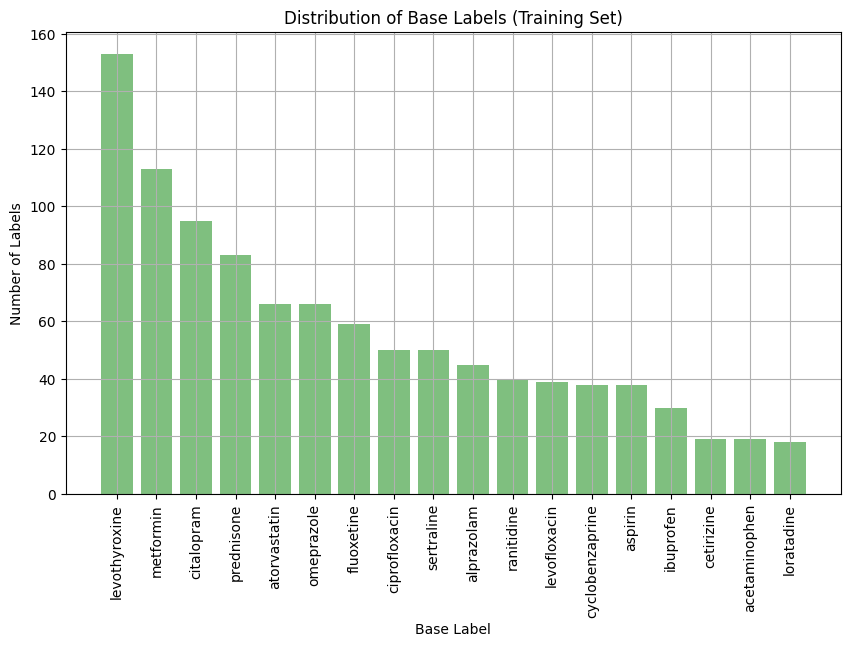

base_label
levothyroxine      735
citalopram         370
metformin          360
prednisone         288
fluoxetine         275
sertraline         170
omeprazole         164
atorvastatin       160
alprazolam         140
ranitidine         138
cyclobenzaprine    134
ciprofloxacin      123
aspirin            100
ibuprofen           96
levofloxacin        92
acetaminophen       40
cetirizine          37
loratadine          14
Name: count, dtype: int64


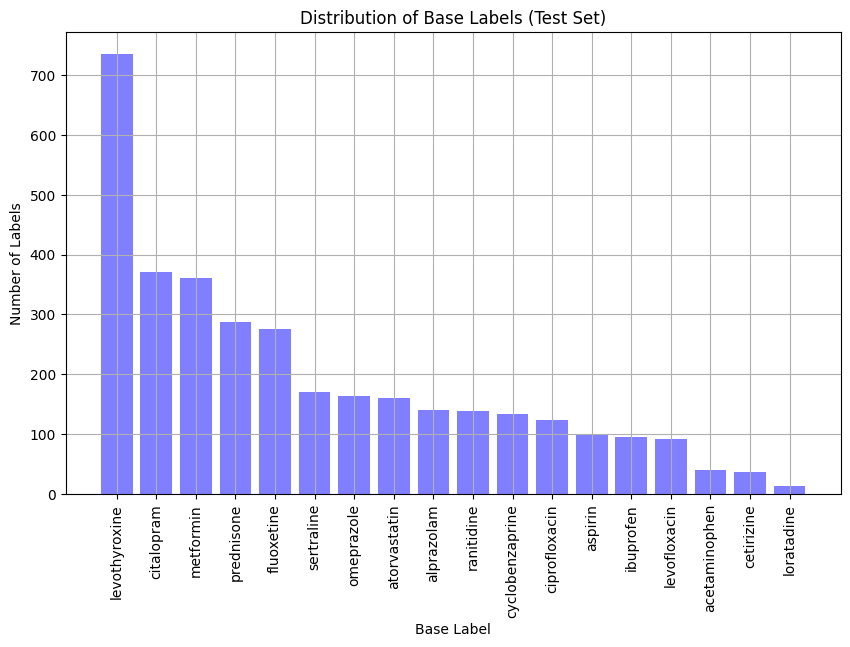

In [7]:
# Check if the data is imbalanced in the training set
label_counts = top20_instances_df['base_label'].value_counts()
print(label_counts)

# Plot the label counts
plt.figure(figsize=(10,6))
plt.bar(label_counts.index, label_counts.values, alpha=0.5, color='g')
plt.title('Distribution of Base Labels (Training Set)')
plt.xlabel('Base Label')
plt.ylabel('Number of Labels')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Check if the data is imbalanced in the test set
test_label_counts = test_df['base_label'].value_counts()
print(test_label_counts)

# Plot the label counts for the test set
plt.figure(figsize=(10,6))
plt.bar(test_label_counts.index, test_label_counts.values, alpha=0.5, color='b')
plt.title('Distribution of Base Labels (Test Set)')
plt.xlabel('Base Label')
plt.ylabel('Number of Labels')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()